    # RSVQAxBEN Model definition, training and evaluation

## 1) Definition of the data loader and encoder

In [ ]:
from comet_ml import Experiment
import json
from tqdm import tqdm

MAX_ANSWERS = 1000
LEN_QUESTION = 20

class VocabEncoder():
  def __init__(self, JSONFile, questions=True):
    self.encoder_type = 'answer'
    if questions:
      self.encoder_type = 'question'
    self.questions = questions
    
    words = {}

    print(f"Reading {JSONFile}..", flush= True, end="")
    with open(JSONFile) as json_data:
      data = json.load(json_data)[self.encoder_type + 's']
    print("Done.")
    
    print(f"Parsing {JSONFile}..", flush= True, end="")
    for i in tqdm(range(len(data))):
      if data[i]["active"]:
        sentence = data[i][self.encoder_type]
        if sentence[-1] == "?" or sentence[-1] == ".":
          sentence = sentence[:-1]
        
        tokens = sentence.split()
        for tok in tokens:
          tok = tok.lower()
          if tok not in words:
            words[tok] = 1
          else:
            words[tok] += 1
            
    #Free the memory:
    data = None
    print("Done.")
        
    sorted_words = sorted(words.items(), key=lambda kv: kv[1], reverse=True)
    print(f"List of words found: {sorted_words}")
    self.words = {'<eos>':0}
    self.list_words = ['<eos>']
    for i, word in enumerate(sorted_words):
      if self.encoder_type == 'answer':
        if i >= MAX_ANSWERS:
          break
      self.words[word[0]] = i + 1
      self.list_words.append(word[0])
    
  def encode(self, sentence):
    res = []
    if sentence[-1] == "?" or sentence[-1] == ".":
      sentence = sentence[:-1]
      
    tokens = sentence.split()
    for tok in tokens:
      tok = tok.lower()
      res.append(self.words[tok] + 1)
    
    res.append(self.words['<eos>'] + 1)
    
    if self.questions:
      while len(res) < LEN_QUESTION:
        res.append(0)
      res = res[:LEN_QUESTION]
    return res
  
  
  def getVocab(self):
    return self.list_words
  
  def decode(self, sentence):
    res = ""
    for i in sentence:
      if (self.list_words[i - 1] == "<eos>"):
        break
      res += self.list_words[i - 1]
      res += " "
    res = res[:-1] #remove last space
    if self.questions:
      res += "?"
    return res


In [2]:
encoder_questions = VocabEncoder("LRBENquestions.json", questions=True)
encoder_answers = VocabEncoder("LRBENanswers.json", questions=False)

Reading LRBENquestions.json..Done.
Parsing LRBENquestions.json..

100%|██████████| 14758150/14758150 [00:55<00:00, 265579.65it/s]


Done.
List of words found: [('are', 14758150), ('in', 9653032), ('the', 9291465), ('there', 6295016), ('some', 6114183), ('present', 5954444), ('areas', 4888928), ('and', 4787619), ('image', 4400876), ('scene', 4399839), ('land', 3647267), ('or', 3501338), ('classes', 2846757), ('agricultural', 2113543), ('wetlands', 2013231), ('forest', 1943481), ('water', 1899847), ('cover', 1657723), ('artificial', 1631795), ('bodies', 1590253), ('what', 1575819), ('arable', 1466111), ('which', 1270938), ('waters', 1198635), ('inland', 1150434), ('urban', 1118943), ('forests', 1035504), ('fabric', 918792), ('coniferous', 914116), ('mixed', 871449), ('pastures', 871375), ('addition', 852317), ('to', 852317), ('besides', 851745), ('transitional', 776122), ('heterogeneous', 743159), ('non-irrigated', 732581), ('natural', 724905), ('crops', 724781), ('marine', 699624), ('with', 694785), ('broad-leaved', 635792), ('woodland/shrub', 622851), ('vegetation', 608011), ('permanent', 578210), ('principally', 5

100%|██████████| 14758150/14758150 [00:21<00:00, 688576.61it/s]


Done.
List of words found: [('no', 7320314), ('yes', 4591079), ('and', 1662640), ('land', 1012072), ('forest', 810342), ('arable', 800156), ('areas', 788545), ('forest,', 619288), ('mixed', 543087), ('non-irrigated', 528964), ('coniferous', 508847), ('agricultural', 475963), ('transitional', 462807), ('woodland/shrub', 462256), ('natural', 434149), ('none', 418265), ('with', 418103), ('principally', 400378), ('occupied', 400378), ('by', 400378), ('agriculture,', 400378), ('significant', 400378), ('of', 400378), ('broad-leaved', 377696), ('water', 336485), ('pastures', 328717), ('urban', 312468), ('complex', 299599), ('cultivation', 299599), ('bodies', 296618), ('areas,', 289231), ('vegetation', 271573), ('heterogeneous', 246066), ('land,', 228784), ('forests', 192226), ('fabric', 185021), ('discontinuous', 178061), ('patterns,', 172848), ('waters', 159544), ('vegetation,', 155882), ('inland', 128371), ('patterns', 126751), ('fabric,', 125116), ('artificial', 105454), ('agro-forestry', 

In [3]:
import os.path
import json
import random
from tqdm import tqdm

import numpy as np
from skimage import io

from torch.utils.data import Dataset
import torchvision.transforms as T


class VQALoader(Dataset):
  def __init__(self, imgFolder, images_file, questions_file, answers_file, encoder_questions, encoder_answers, train=True, ratio_images_to_use = 1, transform=None, number_outputs=1000, selected_answers=None, patch_size=120):
    self.transform = transform
    self.encoder_questions = encoder_questions
    self.encoder_answers = encoder_answers
    self.train = train
    self.imgFolder = imgFolder
    
    print("Loading JSONs...", flush=True, end="")
    with open(questions_file) as json_data:
      questionsJSON = json.load(json_data)
      
    with open(answers_file) as json_data:
      answersJSON = json.load(json_data)
      
    with open(images_file) as json_data:
      imagesJSON = json.load(json_data)
    print("Done.", flush=True)
    
    images = [img['id'] for img in imagesJSON['images'] if img['active']]
    images = images[:int(len(images)*ratio_images_to_use)]
    self.img_ids = images
    
    print("Construction of the Dataset", flush=True, end="")
    if train:
        self.freq_dict = {}
        for i, image in enumerate(tqdm(images)):
          for questionid in imagesJSON['images'][image]['questions_ids']:
            question = questionsJSON['questions'][questionid]

            answer_str = answersJSON['answers'][question["answers_ids"][0]]['answer']
            if answer_str not in self.freq_dict:
                self.freq_dict[answer_str] = 1
            else:
                self.freq_dict[answer_str] += 1

        self.freq_dict = sorted(self.freq_dict.items(), key=lambda x: x[1], reverse=True)
        self.selected_answers = []
        self.non_selected_answers = []
        coverage = 0
        total_answers = 0

        for i, key in enumerate(self.freq_dict):
            if i < number_outputs:
                self.selected_answers.append(key[0])
                coverage += key[1]
            else:
                self.non_selected_answers.append(key[0])
            total_answers += key[1]

        print(f"The {number_outputs} most frequent answers cover {coverage/total_answers*100}% of the total answers.")
    else:
        self.selected_answers = selected_answers

    self.images = np.empty((len(images), patch_size, patch_size, 3), dtype=np.uint8)
    self.images_questions_answers = []
    for i, image in enumerate(tqdm(images)):
      self.images[i, :, :, :] = io.imread(os.path.join(self.imgFolder, str(image) +'.tif'))
      for questionid in imagesJSON['images'][image]['questions_ids']:
        question = questionsJSON['questions'][questionid]
      
        question_str = question["question"]
        type_str = question["type"]
        answer_str = answersJSON['answers'][question["answers_ids"][0]]['answer']
        if self.selected_answers == None:
            self.images_questions_answers.append([self.encoder_questions.encode(question_str), self.encoder_answers.encode(answer_str), i, image, type_str])
        else:
            if answer_str in self.selected_answers:
                self.images_questions_answers.append([self.encoder_questions.encode(question_str), self.selected_answers.index(answer_str), i, image, type_str])
    print("Done.")

  def __len__(self):
    return len(self.images_questions_answers)
  
  def __getitem__(self, idx):
    question = self.images_questions_answers[idx]
    img = self.images[question[2]]
    if self.train:
      if random.random() < .5:
        img = np.flip(img, axis = 0)
      if random.random() < .5:
        img = np.flip(img, axis = 1)
      if random.random() < .5:
        img = np.rot90(img, k=1)
      if random.random() < .5:
        img = np.rot90(img, k=3)
    if self.transform:
      imgT = self.transform(img.copy())
    if self.train:
      return np.array(question[0], dtype='int16'), np.array(question[1], dtype='int16'), imgT
    else:
      return np.array(question[0], dtype='int16'), np.array(question[1], dtype='int16'), imgT, question[4], T.ToTensor()(img / 255), question[3]

In [4]:
data_files = {
    "train":{
        "images":"RSVQAxBEN_split_train_images.json",
        "questions":"RSVQAxBEN_split_train_questions.json",
        "answers":"RSVQAxBEN_split_train_answers.json"
    },
    "validation":{
        "images":"RSVQAxBEN_split_val_images.json",
        "questions":"RSVQAxBEN_split_val_questions.json",
        "answers":"RSVQAxBEN_split_val_answers.json"
    },
    "test":{
        "images":"RSVQAxBEN_split_test_images.json",
        "questions":"RSVQAxBEN_split_test_questions.json",
        "answers":"RSVQAxBEN_split_test_answers.json"
    },
    "all":{
        "images":"LRBENimages.json",
        "questions":"LRBENquestions.json",
        "answers":"LRBENanswers.json"
    }
}

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
transform = T.Compose([
    T.ToTensor(),            
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
  ])

number_outputs = 1000
ratio_images_to_use=1
patch_size=120
dataset = {}
dataset["train"] = VQALoader("Images", data_files["train"]["images"], data_files["train"]["questions"], data_files["train"]["answers"], encoder_questions, encoder_answers, train=True, transform=transform, number_outputs = number_outputs, ratio_images_to_use=ratio_images_to_use, patch_size=patch_size)
dataset["validation"] = VQALoader("Images", data_files["validation"]["images"], data_files["validation"]["questions"], data_files["validation"]["answers"], encoder_questions, encoder_answers, train=False, transform=transform, selected_answers=dataset["train"].selected_answers, ratio_images_to_use=ratio_images_to_use, patch_size=patch_size)

Loading JSONs...Done.
Construction of the Dataset

  0%|          | 0/344385 [00:00<?, ?it/s]

The 1000 most frequent answers cover 98.14973358305384% of the total answers.


100%|██████████| 344385/344385 [12:25<00:00, 462.13it/s]  


Done.
Loading JSONs...Done.
Construction of the Dataset

100%|██████████| 56829/56829 [02:05<00:00, 451.93it/s]


Done.


## 2) Model definition
We take the model presented in TODO

In [5]:
from torchvision import models as torchmodels
import torch.nn as nn
import models.seq2vec
import torch.nn.functional as F
import torch


VISUAL_OUT = 2048
QUESTION_OUT = 2400
FUSION_IN = 1200
FUSION_HIDDEN = 256
DROPOUT_V = 0.5
DROPOUT_Q = 0.5
DROPOUT_F = 0.5

class VQAModel(nn.Module):
    def __init__(self, vocab_questions, input_size = 120, number_outputs=100):
        super(VQAModel, self).__init__()
        
        self.dropoutV = torch.nn.Dropout(DROPOUT_V)
        self.dropoutQ = torch.nn.Dropout(DROPOUT_Q)
        self.dropoutF = torch.nn.Dropout(DROPOUT_F)
        self.seq2vec = models.seq2vec.factory(vocab_questions, {'arch': 'skipthoughts', 'dir_st': 'data/skip-thoughts', 'type': 'BayesianUniSkip', 'dropout': 0.25, 'fixed_emb': False})
        for param in self.seq2vec.parameters():
            param.requires_grad = False
        self.linear_q = nn.Linear(QUESTION_OUT, FUSION_IN)
        
        self.visual = torchmodels.resnet152(pretrained=True)
        extracted_layers = list(self.visual.children())
        extracted_layers = extracted_layers[0:8] #Remove the last fc and avg pool
        self.visual = torch.nn.Sequential(*(list(extracted_layers)))
        for param in self.visual.parameters():
            param.requires_grad = False
        
        self.visual_body = self.visual
        output_size = round((input_size / 32))**2
        self.visual_end = torch.nn.Conv2d(VISUAL_OUT,int(VISUAL_OUT/output_size),1)
        self.linear_v = nn.Linear(VISUAL_OUT, FUSION_IN)
        
        self.linear_classif1 = nn.Linear(FUSION_IN, FUSION_HIDDEN)
        self.linear_classif2 = nn.Linear(FUSION_HIDDEN, number_outputs)
        
    def forward(self, input_v, input_q):
        x_v = self.visual_body(input_v)
        x_v = self.visual_end(x_v)
        x_v = x_v.view(-1, VISUAL_OUT)
        x_v = self.dropoutV(x_v)
        x_v = self.linear_v(x_v)
        x_v = x_v.tanh()
        
        x_q = self.seq2vec(input_q)
        x_q = self.dropoutV(x_q)
        x_q = self.linear_q(x_q)
        x_q = x_q.tanh()
        
        x = torch.mul(x_v, x_q)
        x = x.tanh()
        x = self.dropoutF(x)
        x = self.linear_classif1(x)
        x = x.tanh()
        x = self.dropoutF(x)
        x = self.linear_classif2(x)
        
        return x

In [6]:
model = VQAModel(encoder_questions.getVocab(), number_outputs=number_outputs)

## 3) Training the model

In [7]:
import matplotlib.pyplot as plt

hyper_params = {
    "optimizer":"Adam",
    "batch_size": 1024,
    "num_epochs": 10,
    "learning_rate": 10**-6,
    #For logging purposes
    "ratio_images_to_use": ratio_images_to_use,
    "number_outputs": number_outputs
}

if hyper_params['optimizer'] == "Adam":
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad,model.parameters()), lr=hyper_params['learning_rate'])
else:
    optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad,model.parameters()), lr=hyper_params['learning_rate'])
criterion = torch.nn.CrossEntropyLoss(reduction='sum')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = model.to(device)

loaders = {}
for step in ["train", "validation"]:
    train = step == "train"
    loaders[step] = torch.utils.data.DataLoader(dataset[step], batch_size=hyper_params['batch_size'], shuffle=train, num_workers=0)          

Using device: cuda


In [ ]:
experiment = Experiment(, project_name="vqaxben",workspace="sylvainlobry",log_code=True)

experiment.log_parameters(hyper_params)

losses = {"train":[], "validation":[]}
number_iters = {"train":0, "validation":0}

for epoch in range(hyper_params['num_epochs']):
    print(f"Starting epoch {epoch}:")

    for step in ["train", "validation"]:
        if step == "train":
            model.train()
        else:
            model.eval()
        
        total_correct = 0
        with torch.set_grad_enabled(step == "train"):
            losses[step].append(0)

            for i, data in enumerate(tqdm(loaders[step])):
                if step == "train":
                    question, answer, image = data
                else:
                    question, answer, image, type_str, image_original, _ = data
                    
                question = torch.tensor(question).long().to(device)
                answer = torch.tensor(answer).long().to(device)
                image = torch.tensor(image).float().to(device)
                
                #Run the model and compute the loss
                pred = model(image, question)
                loss = criterion(pred, answer)
                if step == "train":
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                losses[step][epoch] += loss.cpu().item()
                
                #Compute the accuracy
                _, predicted = torch.max(pred.data, 1)
                batch_correct = (predicted == answer.data).sum()
                total_correct += batch_correct
                
                #Logging
                experiment.log_metric(step+"_loss_batch", loss.cpu().item()/question.size(0), step=number_iters[step])
                experiment.log_metric(step+"_accuracy_batch", batch_correct/question.size(0), step=number_iters[step])
                number_iters[step] += 1

            losses[step][epoch] /= len(dataset[step])
            print(f"{step} loss = {losses[step][epoch]}")
            #Logging
            experiment.log_metric(step+"_loss", losses[step][epoch], epoch=epoch)
            experiment.log_metric(step+"_accuracy", total_correct/len(dataset[step]), epoch=epoch)

        if epoch > 0:
            plt.figure()
            handles = []
            handles.append(plt.plot(losses["train"], label="train")[0])
            handles.append(plt.plot(losses["validation"], label="validation")[0])
            plt.legend(handles=handles)
            plt.show()
        torch.save({"model_state_dict": model.state_dict(),"optimizer":optimizer.state_dict(),"losses":losses, "number_iters": number_iters, "epoch":epoch}, "Model"+experiment.get_key()+".tar")
experiment.end()


In [8]:
model_name = "Modela53ad8bb95074aaca258e428f23061d5.tar"

import copy
selected_answers = copy.deepcopy(dataset["train"].selected_answers)
dataset = None
loaders = None
import gc
gc.collect()

ratio_images_to_use=1
test_dataset = VQALoader("Images", data_files["test"]["images"], data_files["test"]["questions"], data_files["test"]["answers"], encoder_questions, encoder_answers, train=False, transform=transform, selected_answers=selected_answers, ratio_images_to_use=ratio_images_to_use, patch_size=patch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=hyper_params['batch_size'], shuffle=False, num_workers=0)
checkpoint = torch.load(model_name)

model = VQAModel(encoder_questions.getVocab(), number_outputs=number_outputs)
model.load_state_dict(checkpoint['model_state_dict'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

model = model.to(device)

model.eval()

Loading JSONs...Done.
Construction of the Dataset

100%|██████████| 118125/118125 [03:19<00:00, 590.87it/s]


Done.
Using device: cuda


VQAModel(
  (dropoutV): Dropout(p=0.5, inplace=False)
  (dropoutQ): Dropout(p=0.5, inplace=False)
  (dropoutF): Dropout(p=0.5, inplace=False)
  (seq2vec): BayesianUniSkip(
    (embedding): Embedding(130, 620, padding_idx=0)
    (rnn): BayesianGRU(
      (gru_cell): BayesianGRUCell(
        (weight_ir): Linear(in_features=620, out_features=2400, bias=True)
        (weight_ii): Linear(in_features=620, out_features=2400, bias=True)
        (weight_in): Linear(in_features=620, out_features=2400, bias=True)
        (weight_hr): Linear(in_features=2400, out_features=2400, bias=False)
        (weight_hi): Linear(in_features=2400, out_features=2400, bias=False)
        (weight_hn): Linear(in_features=2400, out_features=2400, bias=False)
        (drop_ir): SequentialDropout(0.2500)
        (drop_ii): SequentialDropout(0.2500)
        (drop_in): SequentialDropout(0.2500)
        (drop_hr): SequentialDropout(0.2500)
        (drop_hi): SequentialDropout(0.2500)
        (drop_hn): SequentialDropout

In [9]:
preds = []
GTs = []
types = []
img_ids = []
questions = []

with torch.no_grad():
    for i, data in enumerate(tqdm(test_loader)):
        question, answer, image, type_str, image_original, img_id = data
        question = torch.tensor(question).long().to(device)
        image = torch.tensor(image).float().to(device)

        pred = model(image, question)
        pred = np.argmax(pred.cpu().detach().numpy(), axis=1)

        for batch_index in range(question.shape[0]):
            preds.append(pred[batch_index,...])
            GTs.append(answer[batch_index,...].numpy())
            types.append(type_str[batch_index])
            img_ids.append(img_id[batch_index].data.numpy())
            questions.append(encoder_questions.decode(question[batch_index,...].cpu().data.numpy()))

np.save("out_test3.npy", {"preds":preds,"GTs":GTs,"types":types,"questions": questions, "img_ids":img_ids,"selected_answers":selected_answers})

  0%|          | 0/2853 [00:00<?, ?it/s]c:\users\sylvain\pycharmprojects\vqa_ben\venv\lib\site-packages\ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
c:\users\sylvain\pycharmprojects\vqa_ben\venv\lib\site-packages\ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()
c:\users\sylvain\pycharmprojects\vqa_ben\venv\lib\site-packages\torch\nn\functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
c:\users\sylvain\pychar

In [2]:
import numpy as np
results = np.load("out_test3.npy", allow_pickle=True).item()

In [12]:
from sklearn.metrics import accuracy_score

global_acc = accuracy_score(results["GTs"], results["preds"])

yn_preds = []
yn_gts = []
LC_preds = []
LC_gts = []

for i, ans in enumerate(results["GTs"]):
    if selected_answers[ans] == "yes" or selected_answers[ans] == "no":
        yn_preds.append(results["preds"][i])
        yn_gts.append(ans)
    else:
        LC_preds.append(results["preds"][i])
        LC_gts.append(results["GTs"][i])
        
yn_acc = accuracy_score(yn_gts, yn_preds)
LC_acc = accuracy_score(LC_gts, LC_preds)

print(f"Global accuracy: {'{:.2f}'.format(global_acc*100)}%")
print(f"Yes/No accuracy: {'{:.2f}'.format(yn_acc*100)}%")
print(f"LC accuracy: {'{:.2f}'.format(LC_acc*100)}%")

Global accuracy: 69.83%
Yes/No accuracy: 79.92%
LC accuracy: 20.57%


c:\users\sylvain\pycharmprojects\vqa_ben\venv\lib\site-packages\ipykernel_launcher.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
c:\users\sylvain\pycharmprojects\vqa_ben\venv\lib\site-packages\ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator


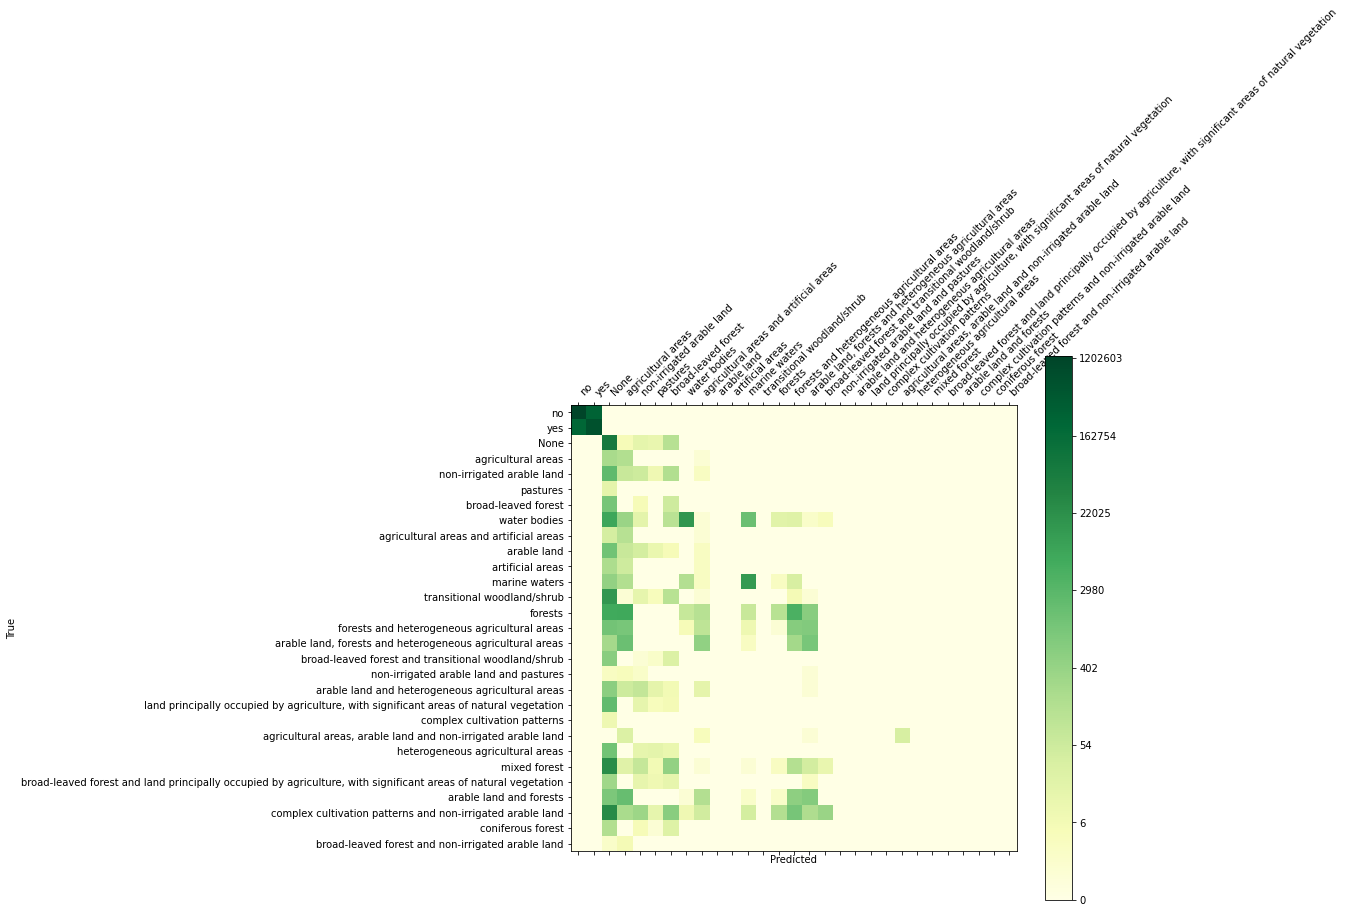

In [3]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(results["GTs"], results["preds"])

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

number_to_plot = 29#len(selected_answers)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(np.log(mat+1)[:number_to_plot,:number_to_plot], cmap="YlGn")
colorbar_ticks = np.array([0,2,4,6,8,10,12,14])
cbar = fig.colorbar(cax)
cbar.set_ticks(colorbar_ticks)
cbar.set_ticklabels(['{:.0f}'.format(x) for x in np.exp(colorbar_ticks)-1])
if number_to_plot < 30:
    ax.set_xticklabels([''] + selected_answers[:number_to_plot], rotation = 45, ha="left")
    ax.set_yticklabels([''] + selected_answers[:number_to_plot])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
else:
    ax.set_xticks([], [])
    ax.set_yticks([], [])

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
fig.savefig('confusion_matrix_' + str(number_to_plot) + '.svg')

In [93]:
count = 0
for index in range(len(results['questions'])):
    if selected_answers[results['GTs'][index]] == 'arable land, forests, heterogeneous agricultural areas, inland waters and urban fabric':
        count += 1
print(count/len(results['questions'])*100)

0.005136147280050485


In [83]:
with open("RSVQAxBEN_split_test_images.json") as json_data:
    imagesJSON = json.load(json_data)

print(imagesJSON['images'][249459])

{'id': 249459, 'date_added': 1607969006.2150314, 'original_name': 'S2B_MSIL2A_20170709T094029_0_26.tif', 'sensor': 'S2', 'upperleft_map_x': 499980, 'upperleft_map_y': 7068840, 'res_x': '10m', 'res_y': '10m', 'people_id': 0, 'type': 'RGB', 'questions_ids': [6236475, 6236476, 6236477, 6236478, 6236479, 6236480, 6236481, 6236482, 6236483, 6236484, 6236485, 6236486, 6236487, 6236488, 6236489, 6236490, 6236491, 6236492, 6236493, 6236494, 6236495, 6236496, 6236497, 6236498, 6236499], 'active': True}


====1950360====
are some water bodies present?
pred: no
GT: no
====1950361====
are some discontinuous urban fabric present?
pred: yes
GT: yes
====1950362====
are some transitional woodland/shrub present?
pred: no
GT: yes
====1950363====
are artificial areas and wetlands present in the image?
pred: no
GT: no
====1950364====
are continuous urban fabric or construction sites and discontinuous urban fabric present?
pred: yes
GT: no
====1950365====
are there water courses and dump sites in the image?
pred: no
GT: no
====1950366====
are some pastures present?
pred: no
GT: no
====1950367====
are coniferous forest and land principally occupied by agriculture, with significant areas of natural vegetation present in the scene?
pred: yes
GT: yes
====1950368====
are salines and water bodies present?
pred: no
GT: no
====1950369====
are there some rice fields?
pred: no
GT: no
====1950370====
are there urban fabric and forests in the scene?
pred: yes
GT: yes
====1950371====
are some urban fabric pres

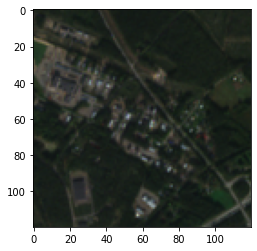

In [75]:
import matplotlib
import os

selected_answers = results['selected_answers']

for index in range(len(results['questions'])):
    if results['img_ids'][index] == 357472:
        print(f"===={index}====")
        print(results['questions'][index])
        print(f"pred: {selected_answers[results['preds'][index]]}")
        print(f"GT: {selected_answers[results['GTs'][index]]}")
        print("=============")
        #test = matplotlib.image.imread(os.path.join('Images',str(results['img_ids'][index]))+'.tif')
        #print(np.mean(test))
        plt.imshow(matplotlib.image.imread(os.path.join('Images',str(results['img_ids'][index]))+'.tif'))


In [38]:
import matplotlib
import os

selected_answers = results['selected_answers']

for index in range(len(results['questions'])):
    if results['img_ids'][index] == 1416:
        print(results['questions'][index])
        print(selected_answers[results['preds'][index]])
        print(selected_answers[results['GTs'][index]])
        #test = matplotlib.image.imread(os.path.join('Images',str(results['img_ids'][index]))+'.tif')
        #print(np.mean(test))
        plt.imshow(matplotlib.image.imread(os.path.join('Images',str(results['img_ids'][index]))+'.tif'))

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
%matplotlib inline

index = 1188548
image = os.path.join('Images',str(results['img_ids'][index])+'.tif')
print(results['img_ids'][index])
question = results['questions'][index].capitalize()
answer = selected_answers[results['GTs'][index]].capitalize()
pred = selected_answers[results['preds'][index]].capitalize()

font = ImageFont.truetype("micross.ttf", 20)

im = Image.open("TemplateAnswerVQA.png")
W, H = im.size
im_sat = Image.open(image)
im_sat = im_sat.resize((512,512))
im.paste(im_sat, (21, 21))

box_question = [(21,550), (531, 639)]

max_char = 50
question_formated = ""
for i in np.arange(0, len(question), max_char):
  if i > 0:
    question_formated += "\n"
  start = i
  end = i + 50
  if end > len(question):
    end = len(question)
  question_formated += question[start:end]

draw = ImageDraw.Draw(im)
w, h = draw.multiline_textsize(question_formated, font=font, spacing=0)
to_put_w = box_question[0][0] + ((box_question[1][0] - box_question[0][0]) - w) / 2
to_put_h = box_question[0][1] + ((box_question[1][1] - box_question[0][1]) - h) / 2
draw.multiline_text((to_put_w, to_put_h), question_formated, fill="black", font=font, align="center")

fontsize = 30
if len(answer) >= 15 or len(pred) >= 15:
  fontsize = 20
font = ImageFont.truetype(os.path.join("/content/drive/My Drive/RSVQA/", "micross.ttf"), fontsize)

box_gt = [(21, 640), (276, 727)]
w, h = draw.textsize(answer, font=font)
to_put_w = box_gt[0][0] + ((box_gt[1][0] - box_gt[0][0]) - w) / 2
to_put_h = box_gt[0][1] + ((box_gt[1][1] - box_gt[0][1]) - h) / 2
draw.multiline_text((to_put_w, to_put_h), answer, fill="black", font=font, align="center")

if pred == answer:
  fill = "green"
else:
  fill = "red"
box_pred = [(277, 640), (531, 727)]
w, h = draw.textsize(pred, font=font)
to_put_w = box_pred[0][0] + ((box_pred[1][0] - box_pred[0][0]) - w) / 2
to_put_h = box_pred[0][1] + ((box_pred[1][1] - box_pred[0][1]) - h) / 2
draw.multiline_text((to_put_w, to_put_h), pred, fill=fill, font=font, align="center")


fig = plt.figure(dpi=512)
plt.imshow(im)
plt.axis('off')
plt.show()

fig.savefig(os.path.join("Output", f"{index}.png"), bbox_inches=0)

249459


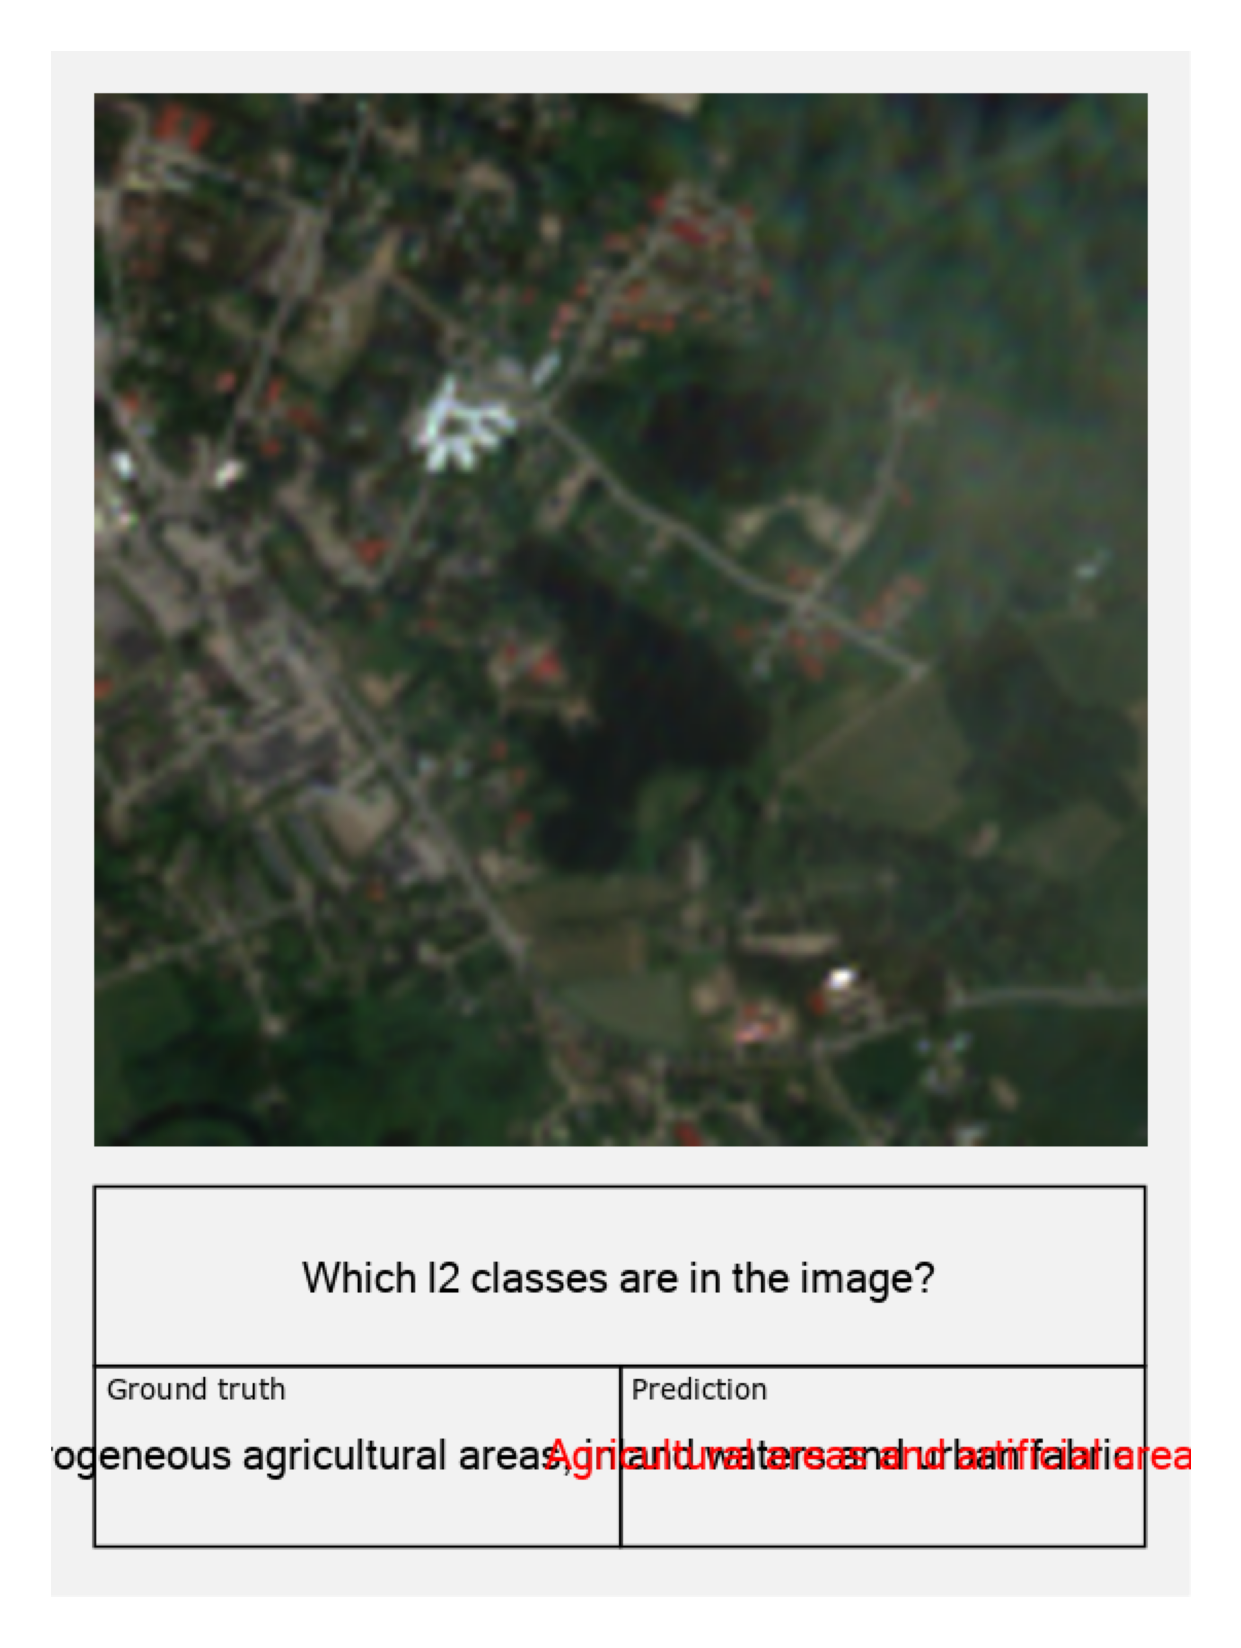

In [82]:
bins = [x for x in range(50)] + [x for x in np.arange(50,1000,20)]
plt.hist([x.item() for x in results["preds"]], bins=bins)
plt.yscale('log')
plt.show()

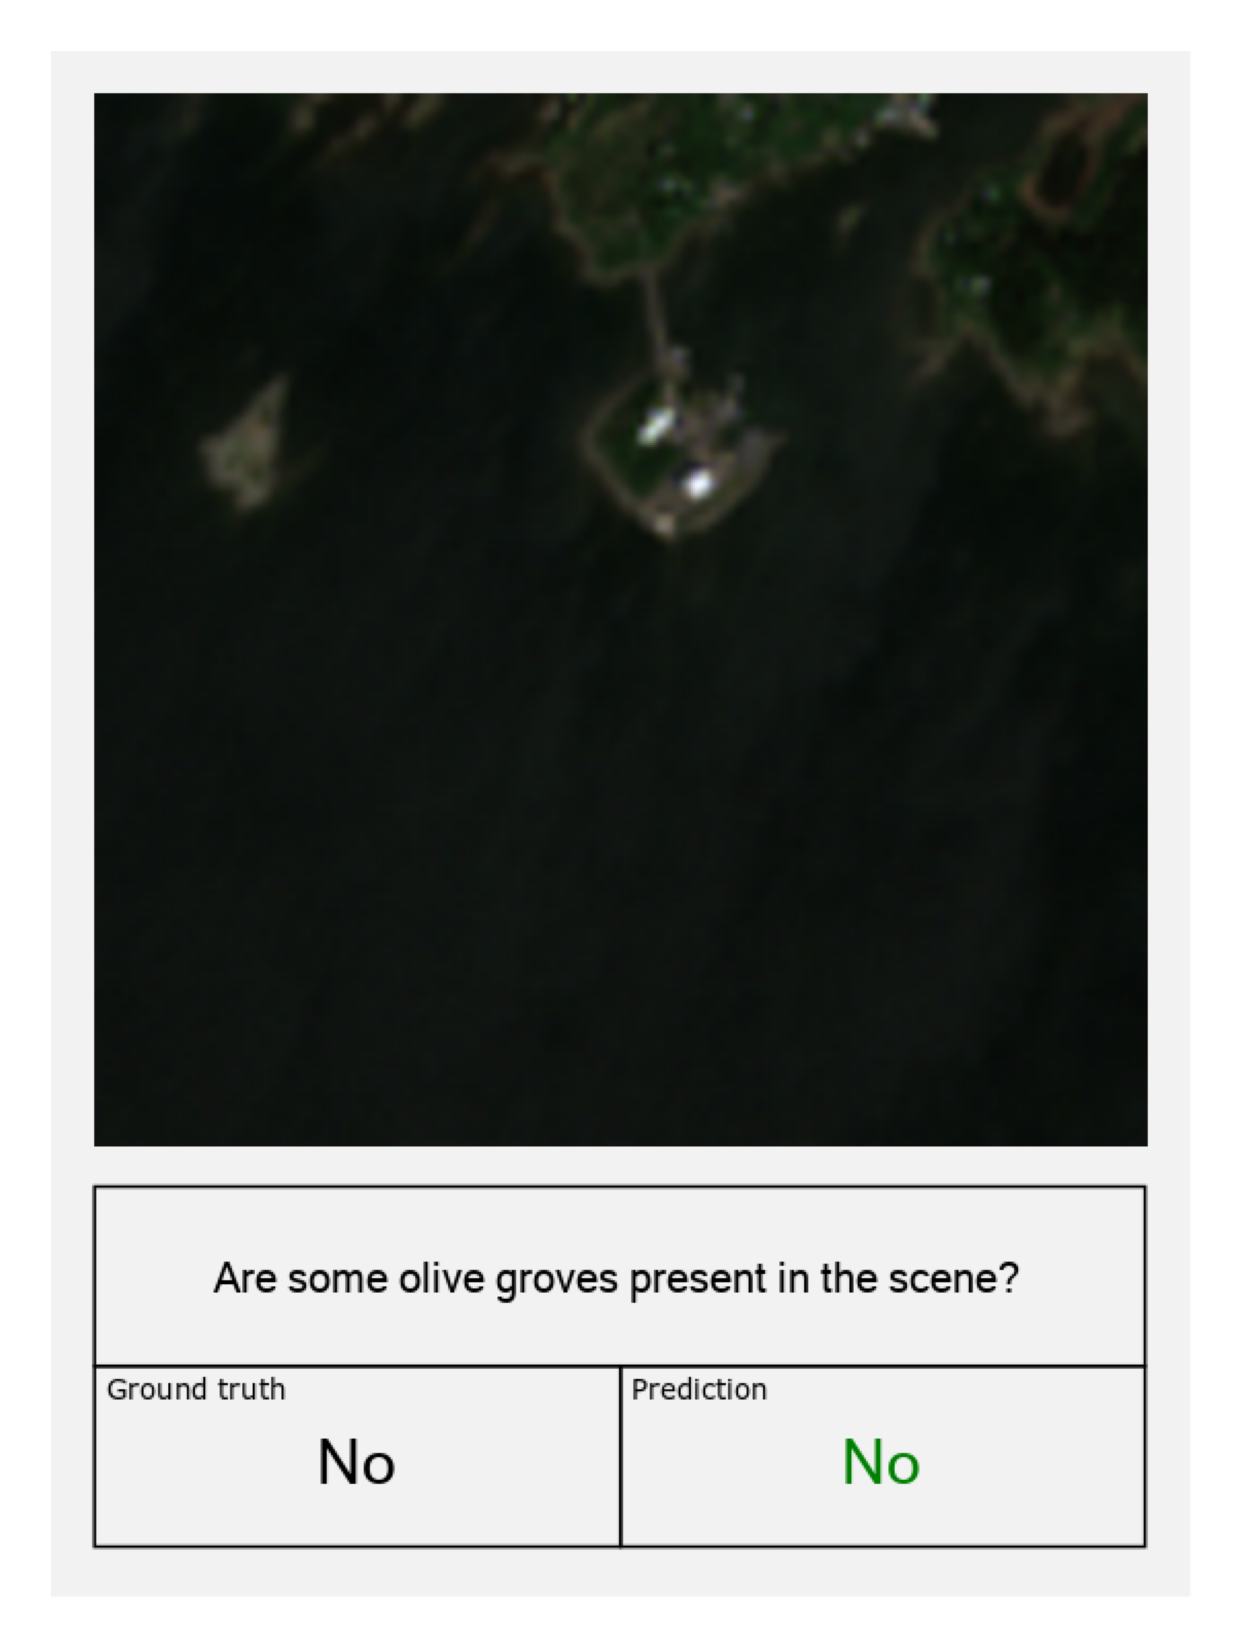

In [32]:
bins = [x for x in range(50)] + [x for x in np.arange(50,1000,20)]
plt.hist([x.item() for x in results["preds"]], bins=bins)
plt.yscale('log')
plt.show()

In [20]:
bins = [x for x in range(50)] + [x for x in np.arange(50,1000,20)]
plt.hist([x.item() for x in results["preds"]], bins=bins)
plt.yscale('log')
plt.show()

17

In [ ]:
bins = [x for x in range(50)] + [x for x in np.arange(50,1000,20)]
plt.hist([x.item() for x in results["preds"]], bins=bins)
plt.yscale('log')
plt.show()

In [ ]:
number_samples = len(results["types"])

predsLC = np.select(np.array(results["types"]) == "LC", np.array(results["preds"]))
predsLC

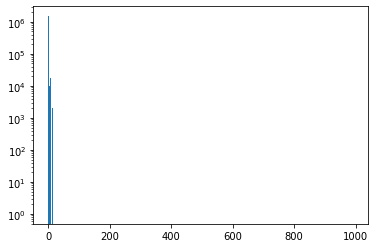

In [90]:
number_samples = len(results["types"])

predsLC = np.select(np.array(results["types"]) == "LC", np.array(results["preds"]))
predsLC

In [68]:
number_samples = len(results["types"])

predsLC = np.select(np.array(results["types"]) == "LC", np.array(results["preds"]))
predsLC

array(7, dtype=int64)